In [2]:
%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.renderer import FoVOrthographicCameras
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

s = 1.8
dist = 1

In [3]:
# target frames
from text3d2video.artifacts.anim_artifact import AnimationArtifact


n_frames = 20

angles = torch.linspace(0, 360, n_frames)
xs = torch.linspace(-0.5, 0.5, 20)
R, T = front_facing_extrinsics(degrees=angles, zs=dist)

frame_cams = FoVOrthographicCameras(R=R, T=T, device="cuda", scale_xyz=[(s, s, s)])
frame_meshes = mesh.extend(len(frame_cams))

# animation = AnimationArtifact.from_wandb_artifact_tag('handstand:latest')
animation = AnimationArtifact.from_wandb_artifact_tag('swing:latest')
frame_indices = animation.frame_indices(n_frames)
frame_cams, frame_meshes = animation.load_frames(frame_indices)

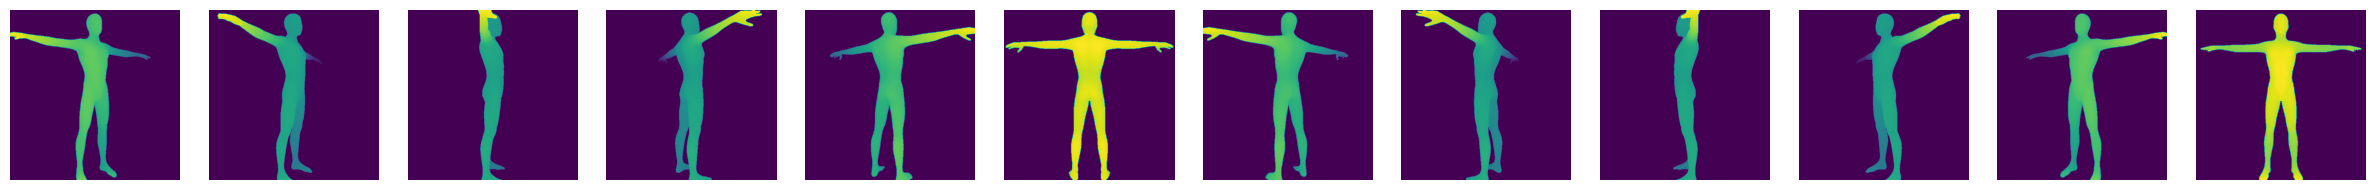

In [4]:
import numpy as np

from text3d2video.utilities.camera_placement import turntable_extrinsics
from pytorch3d.renderer import FoVPerspectiveCameras

from text3d2video.utilities.ipython_utils import display_ims

R, T = front_facing_extrinsics(degrees=[0], zs=dist)

aggr_cams = FoVOrthographicCameras(R=R, T=T, device="cuda", scale_xyz=[(s, s, s)])
aggr_meshes = mesh.extend(len(aggr_cams))

angles = np.linspace(0, 360, 12, endpoint=False)
angles = list(reversed(list(angles)))

R, T = turntable_extrinsics(angles=angles, dists=1)
aggr_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=55)
aggr_meshes = mesh.extend(len(aggr_cams))

aggr_depths = render_depth_map(aggr_meshes, aggr_cams)
display_ims(aggr_depths)

In [5]:
from text3d2video.utilities.ipython_utils import display_vid

frame_depths = render_depth_map(frame_meshes, frame_cams)
aggr_depths = render_depth_map(aggr_meshes, aggr_cams)
torch.cuda.empty_cache()

# display_vids([pil_frames_to_clip(aggr_depths), pil_frames_to_clip(frame_depths)])
display(display_vid(pil_frames_to_clip(aggr_depths)))
display(display_vid(pil_frames_to_clip(frame_depths)))

In [6]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.reposable_diffusion_pipeline import (
    ReposableDiffusionPipeline,
)

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

pipe = load_pipeline(ReposableDiffusionPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
from text3d2video.noise_initialization import FixedNoiseInitializer, UVNoiseInitializer
from text3d2video.pipelines.reposable_diffusion_pipeline import ReposableDiffusionConfig

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

rd_config = ReposableDiffusionConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    aggregate_queries=False,
    feature_blend_alpha=0.8,
    attend_to_self_kv=True,
    mean_features_weight=1.0,
    chunk_size=2,
    num_inference_steps=10,
    guidance_scale=9.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Deadpool, simple white background"

noise_initializer = FixedNoiseInitializer()
noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device=device)
generator.manual_seed(0)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    aggr_meshes,
    aggr_cams,
    verts_uvs,
    faces_uvs,
    reposable_diffusion_config=rd_config,
    noise_initializer=noise_initializer,
    generator=generator
)


100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


In [9]:
from text3d2video.utilities.ipython_utils import display_vid

vid_frames = video_frames[0:len(frame_cams)]
aggr_frames = video_frames[len(frame_cams):]

display(display_vid(pil_frames_to_clip(vid_frames)))
display(display_vid(pil_frames_to_clip(aggr_frames)))

In [10]:
len(aggr_frames)
len(aggr_depths)

7

: 